In [1]:
import bisect
import scipy.spatial
import numpy as np
import random
from matplotlib import pyplot as plt


def compute_color_probabilities(pixels, palette, k=9):
    distances = scipy.spatial.distance.cdist(pixels, palette.colors)
    maxima = np.amax(distances, axis=1)

    distances = maxima[:, None] - distances
    summ = np.sum(distances, 1)
    distances /= summ[:, None]

    distances = np.exp(k*len(palette)*distances)
    summ = np.sum(distances, 1)
    distances /= summ[:, None]

    return np.cumsum(distances, axis=1, dtype=np.float32)


def color_select(probabilities, palette):
    r = random.uniform(0, 1)
    i = bisect.bisect_left(probabilities, r)
    return palette[i] if i < len(palette) else palette[-1]


def randomized_grid(h, w, scale):
    assert (scale > 0)

    r = scale//2

    grid = []
    for i in range(0, h, scale):
        for j in range(0, w, scale):
            y = random.randint(-r, r) + i
            x = random.randint(-r, r) + j

            grid.append((y % h, x % w))

    random.shuffle(grid)
    return grid

In [2]:
import cv2
import numpy as np
import math
from sklearn.cluster import KMeans


class ColorPalette:
    def __init__(self, colors, base_len=0):
        self.colors = colors
        self.base_len = base_len if base_len > 0 else len(colors)

    @staticmethod
    def from_image(img, n, max_img_size=200, n_init=10):
        # scale down the image to speedup kmeans
        img = limit_size(img, max_img_size)

        clt = KMeans(n_clusters=n, n_jobs=1, n_init=n_init)
        clt.fit(img.reshape(-1, 3))

        return ColorPalette(clt.cluster_centers_)

    def extend(self, extensions):
        extension = [regulate(self.colors.reshape((1, len(self.colors), 3)).astype(np.uint8), *x).reshape((-1, 3)) for x
                     in
                     extensions]

        return ColorPalette(np.vstack([self.colors.reshape((-1, 3))] + extension), self.base_len)

    def to_image(self):
        cols = self.base_len
        rows = int(math.ceil(len(self.colors) / cols))

        res = np.zeros((rows * 80, cols * 80, 3), dtype=np.uint8)
        for y in range(rows):
            for x in range(cols):
                if y * cols + x < len(self.colors):
                    color = [int(c) for c in self.colors[y * cols + x]]
                    cv2.rectangle(res, (x * 80, y * 80), (x * 80 + 80, y * 80 + 80), color, -1)

        return res

    def __len__(self):
        return len(self.colors)

    def __getitem__(self, item):
        return self.colors[item]

In [3]:
import cv2
import numpy as np

def limit_size(img, max_x, max_y=0):
    if max_x == 0:
        return img

    if max_y == 0:
        max_y = max_x

    ratio = min(1.0, float(max_x) / img.shape[1], float(max_y) / img.shape[0])

    if ratio != 1.0:
        shape = (int(img.shape[1] * ratio), int(img.shape[0] * ratio))
        return cv2.resize(img, shape, interpolation=cv2.INTER_AREA)
    else:
        return img


def clipped_addition(img, x, _max=255, _min=0):
    if x > 0:
        mask = img > (_max - x)
        img += x
        np.putmask(img, mask, _max)
    if x < 0:
        mask = img < (_min - x)
        img += x
        np.putmask(img, mask, _min)


def regulate(img, hue=0, saturation=0, luminosity=0):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV_FULL)
    if hue < 0:
        hue = 255 + hue
    hsv[:, :, 0] += hue
    clipped_addition(hsv[:, :, 1], saturation)
    clipped_addition(hsv[:, :, 2], luminosity)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR_FULL)

In [4]:
import cv2
import math
import numpy as np


class VectorField:
    def __init__(self, fieldx, fieldy):
        self.fieldx = fieldx
        self.fieldy = fieldy

    @staticmethod
    def from_gradient(gray):
        fieldx = cv2.Scharr(gray, cv2.CV_32F, 1, 0) / 15.36
        fieldy = cv2.Scharr(gray, cv2.CV_32F, 0, 1) / 15.36

        return VectorField(fieldx, fieldy)

    def get_magnitude_image(self):
        res = np.sqrt(self.fieldx**2 + self.fieldy**2)
        
        return (res * 255/np.max(res)).astype(np.uint8)

    def smooth(self, radius, iterations=1):
        s = 2*radius + 1
        for _ in range(iterations):
            self.fieldx = cv2.GaussianBlur(self.fieldx, (s, s), 0)
            self.fieldy = cv2.GaussianBlur(self.fieldy, (s, s), 0)

    def direction(self, i, j):
        return math.atan2(self.fieldy[i, j], self.fieldx[i, j])

    def magnitude(self, i, j):
        return math.hypot(self.fieldx[i, j], self.fieldy[i, j])

In [5]:
# Sum of the min & max of (a, b, c)
def hilo(color):
    return color.max() + color.min()

def complement(color):
    k = hilo(color)
    return tuple(k - u for u in color)

In [6]:
import cv2
import argparse
import math
import progressbar

In [7]:
img = cv2.imread('./balloon.jpg')

In [8]:
stroke_scale = int(math.ceil(max(img.shape) / 1000))
print("Stroke width: %d" % stroke_scale)


gradient_smoothing_radius = int(round(max(img.shape) / 50))
print("Gradient smoothing radius: %d" % gradient_smoothing_radius)

Stroke width: 3
Gradient smoothing radius: 51


In [9]:
# convert the image to grayscale to compute the gradient
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

print("Computing color palette...")
palette = ColorPalette.from_image(img, 10)

Computing color palette...


In [10]:
palette.colors

array([[252.68937126, 153.03308383,  76.27979042],
       [230.76934143, 212.22154731, 203.74696292],
       [ 98.9739777 ,  59.7472119 ,  80.37918216],
       [101.13574661, 183.08144796, 167.98642534],
       [244.69591528, 182.2677761 , 124.49470499],
       [223.9045366 , 196.66880045, 178.67687169],
       [239.78862923, 230.5837112 , 227.69707011],
       [203.97310513,  61.47677262,  52.99755501],
       [180.48905109,  92.37591241, 158.22992701],
       [ 80.66942149,  66.79338843, 184.5661157 ]])

In [14]:
for i in range(10):
    (a,b,c) = complement(palette.colors[i])
    a=int(a)
    b=int(b)
    c=int(c)
    color = np.array([a,b,c],dtype=np.uint8)
    palette.extend([(color[0],color[1],color[2])])
# print("Extending color palette...")
palette = palette.extend([(0, 50, 0), (15, 30, 0), (-15, 30, 0)])


Computing gradient...
Smoothing gradient...
Drawing image...


100% (46 of 46) |#########################| Elapsed Time: 0:00:16 Time: 0:00:16


True

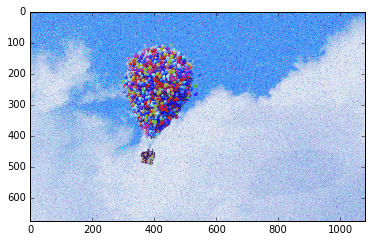

In [16]:

print("Computing gradient...")
gradient = VectorField.from_gradient(gray)

print("Smoothing gradient...")
gradient.smooth(gradient_smoothing_radius)

print("Drawing image...")
# create a "cartonized" version of the image to use as a base for the painting
res = np.zeros((img.shape[0], img.shape[1],3), np.uint8)
res[:,:] = (255,255,255)

res = cv2.medianBlur(res, 11)
# define a randomized grid of locations for the brush strokes
grid = randomized_grid(img.shape[0], img.shape[1], scale=3)
batch_size = 10000

bar = progressbar.ProgressBar()
for h in bar(range(0, len(grid), batch_size)):
    # get the pixel colors at each point of the grid
    pixels = np.array([img[x[0], x[1]] for x in grid[h:min(h + batch_size, len(grid))]])
    # precompute the probabilities for each color in the palette
    # lower values of k means more randomnes
    color_probabilities = compute_color_probabilities(pixels, palette, k=9)

    for i, (y, x) in enumerate(grid[h:min(h + batch_size, len(grid))]):
        color = color_select(color_probabilities[i], palette)
        angle = math.degrees(gradient.direction(y, x)) + 90
        length = int(round(stroke_scale + stroke_scale * math.sqrt(gradient.magnitude(y, x))))

        # draw the brush stroke
        cv2.ellipse(res, (x, y), (stroke_scale, stroke_scale), angle, 0, 360, color, -1, cv2.LINE_AA)


plt.imshow(limit_size(cv2.cvtColor(res, cv2.COLOR_BGR2RGB), 1080))
cv2.imwrite('minion_out.png', res)
# cv2.waitKey(0)